# Tutorial 1: Creating and Solving Factor Graphs
In this tutorial you will learn how to create, solve, and explore factor graphs, as well as what variables, factors, and priors are.

**API Version: Caesar.jl**

## Overview

### Background

To help scope the conversation, we sketch a ubiquitous problem where robotic technologies can have a major impact.  
These tutorials apply broadly to "robotics", and it is worth noting that we define 'robotics' to include 
- Digital Twin computations from various data, 
- Statically mounted robot arms or sensors,
- Human operated measurement equipment, 
- Fully mobile and self propelled "robots", 
- and many more.

### Application Focus

Zooming in further, let's consider a factory environment where various interacting robotic equipment are producing and transporting objects -- i.e. manufacturing and logistics support.  The figure below conceptually shows how a product winds it's way from the factory floor, through various robotic handovers, and out via shipping on a truck.  Each robot individually needs a geometrical (and later semantic) understanding of the task object, their location, the surroundings, and of other agents.  Each robot therefore will have it's own navigation solution.

Longer term, these navigation solutions will need to interact.  The figure below shows at the highest level how factor graphs provide a technique / method / roadmap on how to develop more intelligent robotic equipment that can calibrate, localize, map, track, interact, or cooperate:

![Why Factor Graphs](https://github.com/NavAbility/BinderNotebooks/raw/main/static/icra-1/why-factorgraphs.png)

This tutorial starts the conversation on how to overcome the **crux navigation AI software challenge**, and applies to both individual and interacting robotic systems.  This tutorial is the first step in showing how the idea of factor graphs can provide a good engineering balance in flexibility, ease of use, and mathematical foundation.  

This tutorial will show some of the most basic operations that you can perform with factor graphs, and further tutorials will fill in more and more of the features and capabilities.  Keep in mind that this and several more tutorials must be brought together for the necessary feature set to deploy multi-agent environments of interacting humans and robots.

## What is a Factor Graph

Calibration / localization / tracking / mapping / perception problems in robotics can be solved very effectively with factor graphs, which provide a common language to describe the underlying estimation problem from available data; and in a way both humans and computers can easily understand.   A factor graph is a graphical modelling language with two types of nodes, namely variables and factors, which are connected by edges according to how they interact.  This sketch illustrates a simple example with variables, the large circular nodes, and factors, the square nodes -- note, the interactive code segments below will explain how graphs this like are constructed and why:

![Tut1 Graph Sketch](https://github.com/NavAbility/BinderNotebooks/raw/main/static/icra-1/example-fg.png)

Variables represent unknown states that the user wants the computer to estimate, such as the position or orientation of some equipment, or position of landmarks in the environment, or maybe hidden calibration parameters that are difficult to measure directly, and potetially many, many more.

Factors usually represent the interaction between sparse variables based on some measurement data, e.g. the distance from one point to another -- i.e. a range factor.
This is where basic math and measurement functions are included and used during computation.
For example, encoder measurements from wheels, ranges from a laser, or tag readings from a camera.
The variables associated with each data cue / measurement is depicted by the edges eminating from each factor.
Our solution aleady provides a library of standard variables and factors that require zero mathematical input from the user, yet the technology rapidly supports building of new variables and factors, potentially containing exotic computations -- more on that later.

From a technical perspective, factor graphs allow for an **apples and apples** framework where different sensor measurements / data cues can be combined and jointly processed according to their indivual statistical properties.  Factor graphs allow the system developer to think about each measurement on their own, rather than having to deal with the challenging data fusion problem manually.  This **greatly simplifies the problem**, since the rigorous computational aspects are dealt with by factor graph solver and associated algorithms.

Later tutorials will show how to handle low confidence, ambiguous, and 'strange' measurement scenarios.  **This is an interactive tutorials, so let's dive in and navigate a robot!**

> For additional info, see the Caesar.jl docs on [Graph Concepts](https://juliarobotics.org/Caesar.jl/latest/concepts/concepts/#Graph-Concepts) and beyond, for more details on graph factorization, elimination, recycling, federated solutions, data handling, serialization and much more.

### Loading the Packages

First, we will need some packages: 
- `RoME` - Robot Motion Estimate: Tools, Variables, and Factors for simultaneous localization and mapping (SLAM) in roboticss; which forms part of the [Caesar.jl](https://github.com/JuliaRobotics/Caesar.jl) suite of open core packages).
- `GraphPlot`, `RoMEPlotting` are visualizing support packages.
- Additional support packages for simplifying the tutorial are `Cairo` and `Logging`.

Your environment should already have these packages installed, so you can immediate try the `using` code cells below.

> But just in case your environment does not have the packages installed, the `Pkg.add` code cell is provided just in case.  There is no harm in running the install more than once, it might just take a bit more time.

In [ ]:
# Run install if necessary, in case packages are not in your environment for some reason
import Pkg; [Pkg.add(s) for s in ["RoME"; "GraphPlot"; "Logging";"RoMEPlotting";"Cairo"]];

In [1]:
# suppress unnecessary printouts in the notebook
using Logging
Logging.disable_logging(Logging.Warn);

# RoME is one dependency under the umbrella `using Caesar` for solver and robotics libraries
using RoME

# library used for graph visualization
using GraphPlot, Cairo, RoMEPlotting
Gadfly.set_default_plot_size(20cm,15cm)


## Build a factor graph

To create a new factor graph with default settings use the `initfg()` function. 

In [2]:
fg = initfg();

### Variables and Factors 

Variables, denoted as the larger nodes in the figure below, represent state variables of interest such as vehicle or landmark positions, sensor calibration parameters, and more. Variables are likely hidden values that are not directly observed, but we want to estimate them from observed data and at least some minimal algebra structure from probabilistic measurement models.

Factors, the smaller nodes in the figure below, represent the interaction between particular variables, as captured measurement or data cues.  For example, a distance travelled measurement between two pose variables.
Relative factors between variables are probabilistic models that capture the likelihood interactions between variables.  Priors factors (i.e. unary to one variable) represent absolute information to be introduced about that variable, for example a GPS measurement; more on how to introduce distrust of such priors later.

`RoME` provides variables and factors useful to robotics.
We start with a `Pose2` variable, i.e. position and orientation in two dimensions.
To add variables to our factor graph, `fg`, we created above, call `addVariable` with a label `x0` and type `Pose2`


In [3]:
addVariable!(fg, :x0, Pose2);

We now have a factor graph with one variable, but to solve it we need some additional information. 
In this example, we need the estimated starting point of our robot.
We use unary factors called priors to represent absolute information to be introduced. 
In this case we use `PriorPose2`, as our variable type is also `Pose2`.
Since factors represent a probabilistic interaction between variables, we need to specify the distribution our factor will represent. Here we use `MvNormal` which is a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) from [Distributions.jl](https://github.com/JuliaStats/Distributions.jl). 

Let's create a `PriorPose2` unary factor with zero mean and a covariance matrix of (`diagm([0.05,0.05,0.01].^2)`):

$\Sigma = \begin{bmatrix} 0.0025 & 0.0 &  0.0 \\ 0.0 & 0.0025 & 0.0 \\ 0.0 &  0.0 &  0.0001 \end{bmatrix}$



In [ ]:
prior_distribution = MvNormal(zeros(3), diagm([0.05,0.05,0.01].^2))
addFactor!(fg, [:x0], PriorPose2(prior_distribution)) 

We can look at the factor graph we have so far using `plotDFG`.

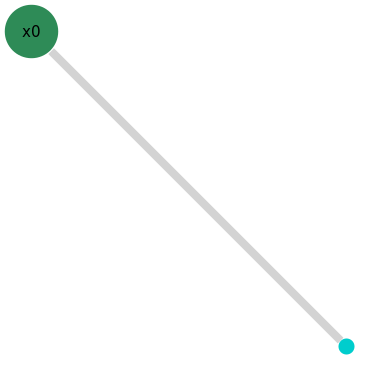

IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1)

In [5]:
pl = DFG.plotDFG(fg)

# Static render workaround, remove with SVG upgrade
io = IOBuffer(); draw(PNG(io,10cm,10cm), pl); io

The prior is now connected to the variable, `x0`, but it is not initialized yet. Automatic initialization of variables depends on how the factor graph model is constructed. This tutorial demonstrates this behavior by first showing that `x0` is not initialized:

In [6]:
isInitialized(fg, :x0)

false

**Graph-based Initialization**

At this stage, `x0` is not initialized since the future intentions of the user are unknown, and a deferred initialization strategy is employed.  The underlying solve library, `IncrementalInference.jl`, assumes that the user will generally populate new variable nodes with most of the associated factors before moving to the next variable. By delaying initialization of a new variable (say `x0`) until a second newer uninitialized variable (say `x1`) depends on `x0`, the `IncrementalInference` algorithms can initialize the system with more information from surrounding variables and factors. Note that graph-based initialization of variables is a local operation, while global inference over the entire graph is shown later in this tutorial.

**Robot Odometry - Relative Factor**

Next, we want to add an odometry factor that connects our two robot poses `x0` and `x1` together to form a chain.
Here we use a relative factor of type `Pose2Pose2` with a measurement from pose `x0` to `x1` of (x=1.0,y=0.0,θ=pi/2); the robot drove 1 unit forward (in the x direction).
Similarly to the prior we added above, we use an `NvNormal` distribution to represent the odometry with mean and covariance:

$\mu =(x=1, y=0, \theta=\frac{\pi}{2})$

$\Sigma = \begin{bmatrix} 0.01 & 0.0 &  0.0 \\ 0.0 & 0.01 & 0.0 \\ 0.0 &  0.0 &  0.0001 \end{bmatrix}$


In [ ]:
addVariable!(fg, :x1, Pose2);
odo_distribution = MvNormal([1.0, 0.0, pi/2], diagm([0.1, 0.1, 0.01].^2))
fac_1 = addFactor!(fg, [:x0, :x1], Pose2Pose2(odo_distribution))

Looking at the updated factor graph we now have the newly added variable `x1` connected to `x0` with our odometry factor.

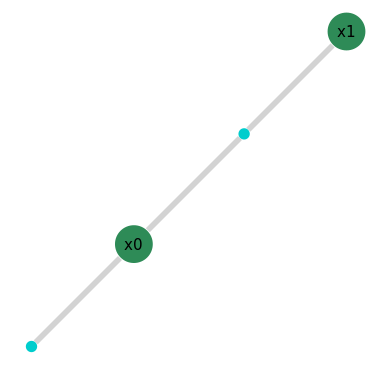

IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1)

In [8]:
pl = DFG.plotDFG(fg)

# Static render workaround, remove with SVG upgrade
io = IOBuffer(); draw(PNG(io,10cm,10cm), pl); io

By adding `x1` and connecting it with a factor to `x0` the automatic initialization of `x0` is triggered. 
Note that the automatic initialization of `x0` is aware that `x1` is not initialized and therefore only used the prior unary factor to initialize the marginal belief estimate for `x0`. The structure of the graph has now been updated to two variable nodes and two factors.

In [9]:
isInitialized(fg, :x0)

true

## Solving

We now have a graph we can solve using the Multi-Modal iSAM (MM-iSAM) algorithm. 
The default solver will perform non-parametric inference/state-estimation over our newly created graph.

Fundamentally, inference is performed via the Bayes (junction) tree where Chapman-Kolmogorov transit integral solutions are based on marginal-joint belief estimation (a sum-product / belief-propagation approximation algorithm). Many benefits such as clique recycling are also available. See the [Solving Graphs](https://juliarobotics.org/Caesar.jl/latest/concepts/solving_graphs/) section in the documentation for more detail.

In [ ]:
solveGraph!(fg);

A _slightly_ more the mathy explination.  A factor graph represents the factorization of the overall joint probability belief function that describes your system.
It represents a breakdown of the complex problem describing your robot navigation, and does so in a way that a computer can work through in a very efficient manner. 
This factorization allows us to solve the optimization (a.k.a. inference) problem for all variables given every measurement described by the factors.

### Multi-Sensor Data Fusion

In our example so far, the graph models the position and orientation (pose) of your robot at any given time, and soon we will add relative measurements to landmarks using a different sensor but captured in the same factor graph. 

## Results

The RoMEPlotting.jl package allows visualization (plotting) of the belief state over any of the variable nodes.

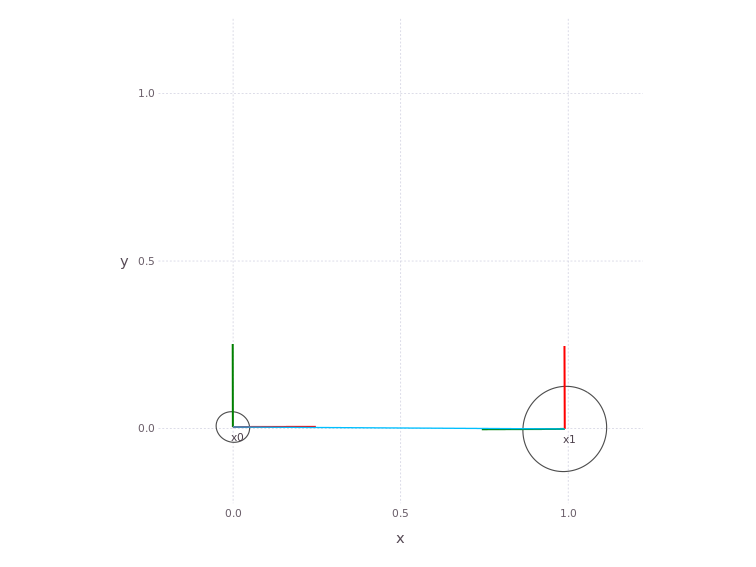

[0.002 -0.0; -0.0 0.002]
[0.016 0.001; 0.001 0.016]


IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1)

In [70]:
pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawPoints=false,
                xmin=-0.2, xmax=1.2, ymin=-0.2, ymax=1.2);

# Static render workaround, remove with SVG upgrade
io = IOBuffer(); draw(PNG(io), pl); io

**What is happening**

The figure shows the position and orientation (red forward) for poses `x0` and `x1`. As well as the covariance ellipse. 
Since the solver used was non-parametric, the covariance ellipse is based on a best Gaussian distribution fit of the full belief.
A few other functions are also handy for interacting with the factor graph, for instance `getVariable` returns the full variable.
Or if you are interested in the suggested Parametric Point Estimate (PPE) use `getPPESuggested`.

In [ ]:
var = getVariable(fg, :x1)

In [72]:
DFG.getPPESuggested(fg, :x1)

3-element Vector{Float64}:
  0.9896571810344401
 -0.0009981445429821584
  1.5744873834590676

**Parametric point estimates and beliefs**

The function `getPPESuggested(fg, :x1)` returns the parametric point estimate for the current belief in variable `x1`.
A PPE can be the maximum or mean of the belief. 
If the belief is a normal distribution, both correspond with its mean. 
However, care should be taken with using PPEs when beliefs might be non-parametric, for example, in a multimodal belief with two peaks, max corresponds with the maximum of the two peaks while the mean will fall somewhere in between them. 
In non-parametric cases, it is better to work with the full belief obtained by the Kernel Density Estimate (KDE).  Kernel Density Estimation is a non-parametric way to estimate the probability density function of a random variable.
With the default solver, a full probability density function is always available and the pose estimate can be visualized using `plotPose`.  Non-parametric solutions will be discussed in more detail in tutorial 2. The plot for pose `x1` is


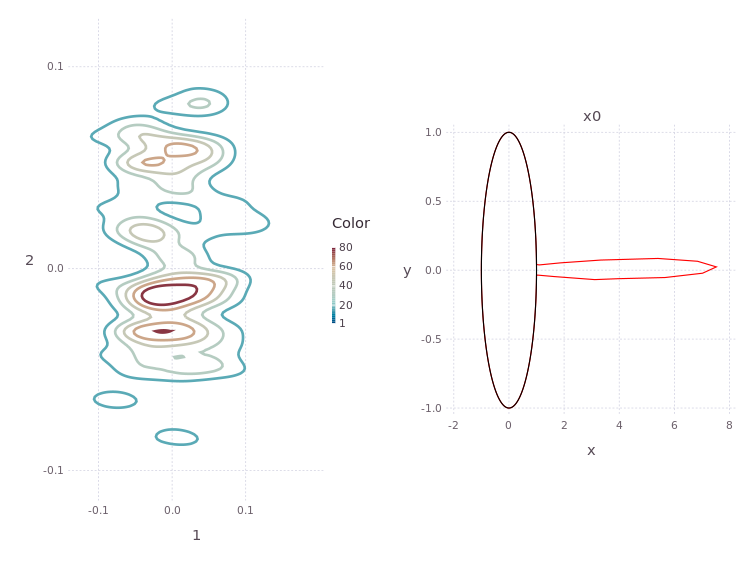

IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1)

In [73]:
pl = plotPose(fg, :x0)

# Static render workaround, remove with SVG upgrade
io = IOBuffer(); draw(PNG(io), pl); io

The next tutorials will show other plotting functions like `plotBelief`.  For yet more information, see the [section on Plotting in the Caesar docs](https://juliarobotics.org/Caesar.jl/latest/concepts/2d_plotting/).

## Adding A Landmark from a Different Sensor

So far we worked with the `Pose2` factor type. 
Among others, `RoME` also provides the `Point2` variable type and `Pose2Point2BearingRange` factor, which we will use to represent a landmark sighting in our factor graph.
We will add a landmark `l1` with bearing range measurement of bearing=$(\mu=0,\sigma=0.03)$ range=$(\mu=0.5,\sigma=0.1)$ and continue our robot trajectory by driving around in a square.

In [ ]:
addVariable!(fg, :l1, Point2)

p2br = Pose2Point2BearingRange(Normal(0.0,0.03),Normal(0.5,0.1))
addFactor!(fg, [:x0,:l1], p2br)

addVariable!(fg, :x2, Pose2)
addFactor!(fg, [:x1,:x2], Pose2Pose2(odo_distribution))

addVariable!(fg, :x3, Pose2)
addFactor!(fg, [:x2,:x3], Pose2Pose2(odo_distribution))

addVariable!(fg, :x4, Pose2)
addFactor!(fg, [:x3,:x4], Pose2Pose2(odo_distribution))

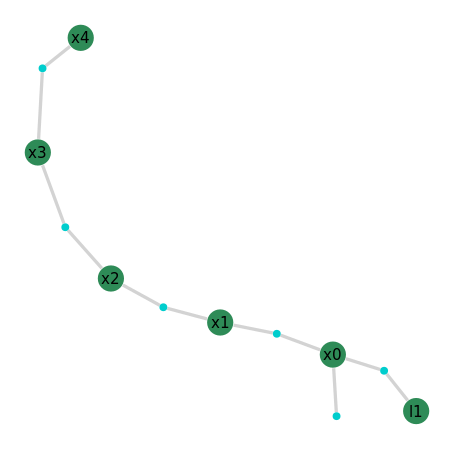

IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1)

In [13]:

pl = DFG.plotDFG(fg)

# Static render workaround, remove with SVG upgrade
io = IOBuffer(); draw(PNG(io,12cm,12cm), pl); io

We now have a longer odometry chain with one landmark sighting, let's solve the factor graph again so we can have a look at the results.

In [75]:
solveGraph!(fg);

Building Bayes net...
Find potential functions for each clique


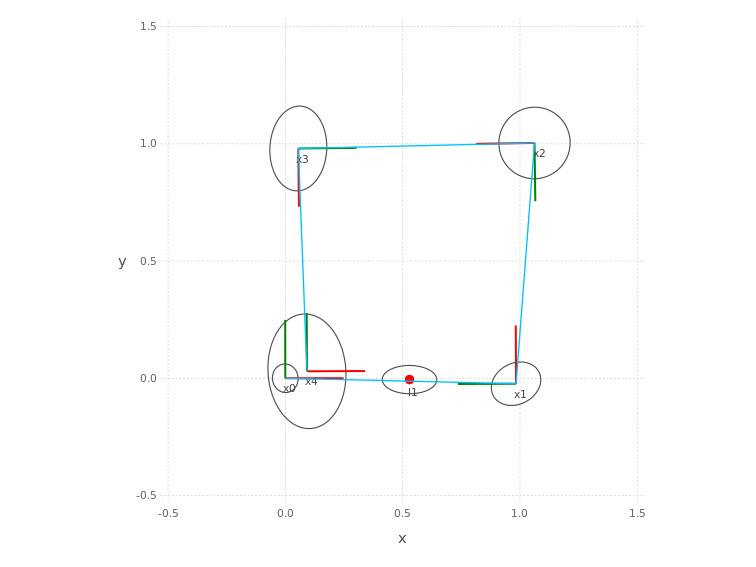

[0.003 -0.0; -0.0 0.004]
[0.011 0.002; 0.002 0.009]
[0.023 0.0; 0.0 0.023]
[0.015 0.001; 0.001 0.033]
[0.028 -0.002; -0.002 0.06]
[0.013 -0.0; -0.0 0.004]


IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1)

In [81]:
pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawPoints=false,
                xmin=-0.5, xmax=1.5, ymin=-0.5, ymax=1.5)

# Static render workaround, remove with SVG upgrade
io = IOBuffer(); draw(PNG(io), pl); io

As expected, the robot continued its square trajectory to end off where it started. 
To illustrate a loop closure, we add another bearing range sighting to from pose `x4` to landmark `l1`, 

In [ ]:
p2br = Pose2Point2BearingRange(Normal(0.0,0.03),Normal(0.5,0.1))
addFactor!(fg, [:x4,:l1], p2br)

then solve the graph and plot the new results:

In [ ]:
solveGraph!(fg);

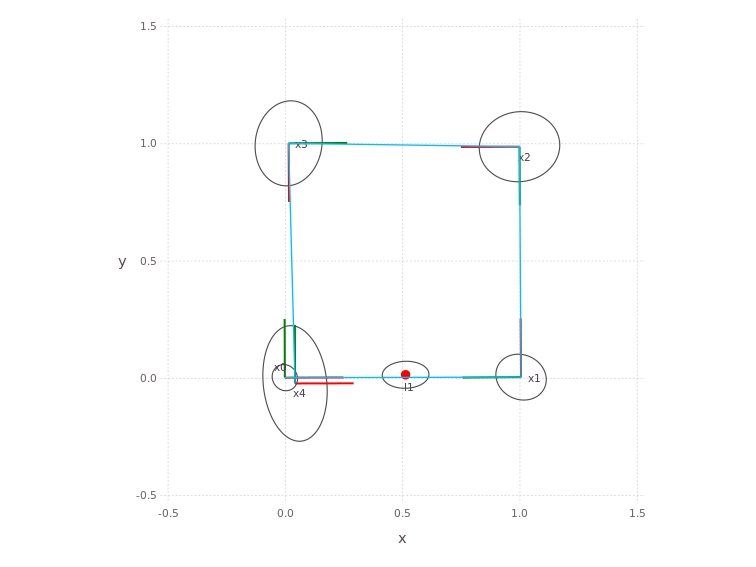

[0.003 -0.0; -0.0 0.003]
[0.012 -0.001; -0.001 0.01]
[0.029 0.001; 0.001 0.022]
[0.02 0.002; 0.002 0.033]
[0.019 -0.005; -0.005 0.061]
[0.01 0.0; 0.0 0.003]


IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1)

In [87]:
pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawPoints=false,
                xmin=-0.5, xmax=1.5, ymin=-0.5, ymax=1.5)

# Static render workaround, remove with SVG upgrade
io = IOBuffer(); draw(PNG(io), pl); io

## Next Steps

Tutorial 2 will give an introduction to non-parametric solutions.

## Additional Resources

### Factors are On-Manifold

The variables used in this tutorial, `Point2` and `Pose2`, are represented as points on manifolds and all algebraic operations, inference/optimization are also performed on manifold.
The [Caesar.jl](https://github.com/JuliaRobotics/Caesar.jl) software stack is based on Manifolds.jl, and lifting the lid a little on how that is implemented, let's look at the underlying manifold:

In [83]:
getManifold(fg[:x1])

SpecialEuclidean(2)

For more information on how manifolds are used in Caesar.jl, refer to
- The [Using Manifolds.jl](https://juliarobotics.org/Caesar.jl/latest/concepts/using_manifolds/) section in the documentation.

### Custom Variables and Factors

In most scenarios, the existing variables and factors should be sufficient for most robotics applications. 
Caesar however, is extensible and allows you to easily incorporate your own variable and factor types for specialized applications.

Have a look at the Caesar documentation if you are interested in creating custom variables, factors (or priors)

- [Custom variables](https://juliarobotics.org/Caesar.jl/latest/examples/custom_variables/)
- [Custom prior factors](https://juliarobotics.org/Caesar.jl/latest/examples/basic_definingfactors/)
- [Custom relative factors](https://juliarobotics.org/Caesar.jl/latest/examples/custom_relative_factors/)

### Bayes (Junction) Tree

Inference is performed on the Bayes tree see: [Bayes tree principles](https://juliarobotics.org/Caesar.jl/latest/principles/bayestreePrinciples/)